In [1]:
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
import numpy as np
import requests
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt



/Users/brunovalan/opt/anaconda3/envs/AIPI540/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-18 15:39:51.919616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np


In [3]:
book_data = pd.read_csv('../Data/duke_books.csv')
book_data.head()

#see how many NA's are in the summary column 
book_data['Summary'].isna().sum()

#drop NA values for now
book_data = book_data.dropna(subset = ['Summary']).reset_index(drop = True)

#look at data head
book_data.head()

,Title,Location,Authors,Summary,Published,Language,System Details,Notes,Description,Description Details,Genre,OCLC,Other Identifiers,System ID
0,1998 vital statistics of the United States : v...,Perkins Public Documents/Maps,National Center for Health Statistics (U.S.),"This CD ROM contains chiefly tables, a guide t...","[Washington, D.C.?] : Dept. of Health and Huma...",English,System requirements for Windows: IBM-compatibl...,"Title from title screen.ISO 9660 format.""Shipp...",1 CD-ROM ; 4 3/4 in.,Dimensions: 4 3/4 in.Color characteristics: po...,"TablesStatistics, Vital",49537646.0,GPO Item Number: 0510,003072700
1,12th Education and Training in Optics and Phot...,NaN,NaN,Proceedings of SPIE present the original resea...,"[S.l.] : [s.n.], 9999.",NaN,NaN,Title from content provider.,1 online resource,NaN,Electronic books,NaN,NaN,008891635
2,13th International Scientific Conference on Op...,NaN,NaN,Proceedings of SPIE present the original resea...,"[S.l.] : [s.n.], 9999.",NaN,NaN,Title from content provider.,1 online resource,NaN,Electronic books,NaN,NaN,008891641
3,16th International Workshop on Physics of Semi...,NaN,NaN,Proceedings of SPIE present the original resea...,"[S.l.] : [s.n.], 9999.",NaN,NaN,Title from content provider.,1 online resource,NaN,Electronic books,NaN,NaN,008891649
4,17th-18th century Burney Collection newspapers...,NaN,"Burney, Charles, 1757-1817",Searchable full-text access to the British Lib...,"[Farmington Hills, Mich.] : Gale Cengage Learn...",English,NaN,NaN,1 online resource,Color characteristics: polychromeFile type: te...,SourcesIndexesOnline databasesElectronic refer...,182626961.0,LCCN: 2013238254,003975405


In [5]:
#many summaries are short and so we don't need to summarize them, lets make a flag column for summary being > 100 words 
def word_count(text): 
    words = text.split()
    return len(words)

#create word count column
book_data['word_count'] = book_data['Summary'].apply(word_count)


520

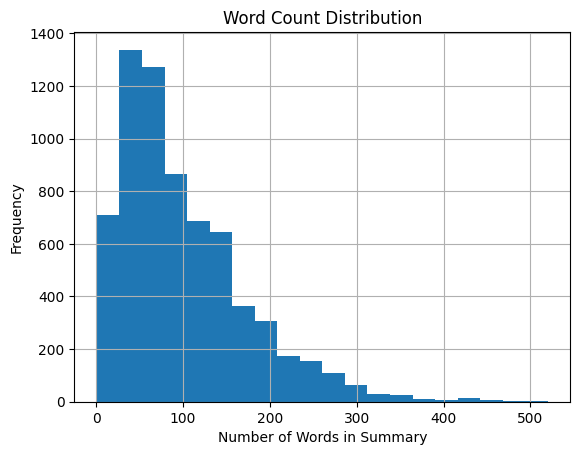

In [6]:
#look at distribution of summary word count - want to get an idea of how many summaries we want to generate/what the cut off shoudl be
book_data['word_count'].hist(bins=20)

#make sure that word count is below model max sequence length - 520 
display(book_data['word_count'].max())

# Set the title and axis labels of the histogram
plt.title('Word Count Distribution')
plt.xlabel('Number of Words in Summary')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

#based on this I can try and use 100 as a cutoff 

In [11]:
#filter for books with longer summaries
book_long = book_data[book_data['word_count'] >= 100] 

#drop everything but title and summary 
book_long = book_long.loc[:, ['Title', 'Summary']]

#generate full combinations of title and text
book_long['full_text'] = book_long.apply(lambda x: ' '.join([x['Title'],x['Summary']]),axis=1)

#see how many observations we have
display(len(book_long))
display(book_long.head())


2755

,Title,Summary,full_text
119,"African American newspapers, 1827-1998. - Duke...",Provides access to U.S. newspapers chronicling...,"African American newspapers, 1827-1998. - Duke..."
130,All the world's primates. - Duke University Li...,All the World's Primates is the comprehensive ...,All the world's primates. - Duke University Li...
137,The American bench. - Duke University Librarie...,Court profiles on both federal and state court...,The American bench. - Duke University Librarie...
140,American Law Institute library. - Duke Univers...,The American Law Institute library on HeinOnli...,American Law Institute library. - Duke Univers...
172,Archives of sexuality & gender. LGBTQ history ...,As part of the Archives of Sexuality & Gender ...,Archives of sexuality & gender. LGBTQ history ...


In [12]:
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")


In [9]:
def truncate_summary(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(inputs["input_ids"], max_length=200, min_length=100, length_penalty=1.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(outputs[0])
    summary = summary.split('</s>')[-2].split('<s>')[-1].strip()
    return summary 


In [ ]:
book_long['abbreviated_summary'] = book_long['full_text'].apply(truncate_summary)

In [62]:
print(books_long_trial.iloc[0][3])

U.S. newspapers chronicled a century and a half of the African American experience. Includes historically significant papers from more than 35 states. Covers life in the Antebellum South, growth of the Black church, the Jim Crow Era, the Great Migration, Harlem Renaissance, Civil Rights movement, and political and economic empowerment. Titles in Series 1 come from the Wisconsin Historical Society, Kansas State Historical Society and Library of Congress, while titles in Series 2 come from American Antiquarian Society, Center for Research Libraries.


In [ ]:
#merge the abbreviated summary back on to the original data fame and fill NA with the original book summary
def add_abstractive_summary(original_df, abbrev_df): 
    merged_df = pd.merge(original_df, abbrev_df, how = 'left', on = 'Title')
    merged_df['abbreviated_summary'].fillna(merged_df['Summary'], inplace=True)
    return merged_df
    
